### Testing Wind Speed -> Wind Power conversion ###

Based on Hannah's S2S4E and CLEARHEADS scripts. First load bias corrected dcppA-hindcast data from HadGEM3-GC31-MM, then use power law to convert from 10m wind speeds to 100m wind speeds (for now), and then convert into wind power and compare to ERA5.

In [1]:
# cell magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load local modules
import os
import sys
import glob
import importlib

# Import external modules
import numpy as np
import pandas as pd
import xarray as xr
import iris
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from tqdm import tqdm

In [2]:
# Import the functions
sys.path.append("/home/users/benhutch/unseen_functions")

import functions_demand as func_dm

import bias_functions as bias_func

import load_wind_functions as lw_func

import European_hourly_hub_height_winds_2023_model as hb_wind_func

In [3]:
# import dictionaries
sys.path.append("/home/users/benhutch/unseen_functions")

import unseen_dictionaries as udicts

In [4]:
# set up the global variables - loading for a single country
first_year = 1960
last_year = 1960  # testing loading full model data now
first_month = 1
last_month = 1
init_years = np.arange(1960, 2018 + 1, 1)
variable = "sfcWind"
lead_time = 1
obs_variable = "si100_bc"  # use bc 100m winds for obs
country = "United Kingdom"
country_name = "United_Kingdom"

# Set up the path to the obs
# observations from ERA5 containing 10m wind speeds (si10)
# and bias corrected 100m wind speeds (si100_bc)
# obs_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_wind_daily_1960_2020.nc"

# Smaller obs path for testing
# process in smaller chunks
obs_path_new = "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_si100_si100_bc_daily_1960_2020.nc"
obs_path_old = "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_si100_bc_daily_1960_2020.nc"
obs_path_test = (
    "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_si100_bc_daily_1960_1961.nc" # now even shorter
)

# bias correction to remove
old_bc = "/home/users/benhutch/UREAD_energy_models_demo_scripts/ERA5_speed100m_mean_factor_v16_hourly.npy"
new_bc = "/home/users/benhutch/for_martin/for_martin/creating_wind_power_generation/GWA_correction_factor_on_ERA5_grid.npy"

# Set up the path to the test file
test_file = "/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1960-r1i1p1f2/day/sfcWind/gn/files/d20200417/sfcWind_day_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1p1f2_gn_19601101-19601230.nc"

In [5]:
# load the obs pathh test with xarray
obs_test = xr.open_dataset(obs_path_test)

# print the variables
print(obs_test)

<xarray.Dataset>
Dimensions:    (time: 731, longitude: 304, latitude: 214)
Coordinates:
  * time       (time) datetime64[ns] 1960-01-01 1960-01-02 ... 1961-12-31
  * longitude  (longitude) float32 -45.0 -44.72 -44.44 ... 39.66 39.94 40.22
  * latitude   (latitude) float32 89.78 89.51 89.23 88.95 ... 30.49 30.21 29.93
Data variables:
    si100_bc   (time, latitude, longitude) float64 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Aug 01 15:49:08 2024: cdo selyear,1960/1961 ERA5_si100_...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...


In [6]:
lons = obs_test.longitude.values
lats = obs_test.latitude.values

In [7]:
lats

array([89.784874, 89.5062  , 89.22588 , 88.94519 , 88.66436 , 88.38346 ,
       88.102516, 87.821556, 87.54058 , 87.25959 , 86.97859 , 86.697586,
       86.41658 , 86.135574, 85.85456 , 85.57355 , 85.29253 , 85.01151 ,
       84.73049 , 84.44947 , 84.16845 , 83.88743 , 83.6064  , 83.32538 ,
       83.04435 , 82.76333 , 82.4823  , 82.20128 , 81.92025 , 81.63923 ,
       81.3582  , 81.07717 , 80.79614 , 80.51512 , 80.23409 , 79.953064,
       79.672035, 79.39101 , 79.10998 , 78.82895 , 78.54792 , 78.26689 ,
       77.98586 , 77.70484 , 77.42381 , 77.142784, 76.861755, 76.58073 ,
       76.2997  , 76.01866 , 75.73763 , 75.456604, 75.175575, 74.89455 ,
       74.61352 , 74.33249 , 74.05146 , 73.77043 , 73.4894  , 73.208374,
       72.927345, 72.64632 , 72.36529 , 72.08425 , 71.80322 , 71.522194,
       71.241165, 70.96014 , 70.67911 , 70.39808 , 70.11705 , 69.83602 ,
       69.554985, 69.27396 , 68.99293 , 68.7119  , 68.43087 , 68.14984 ,
       67.86881 , 67.587776, 67.30675 , 67.02572 , 

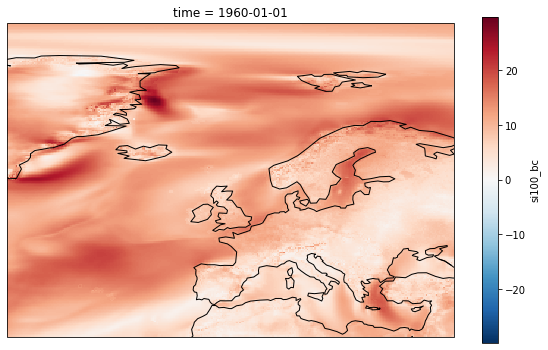

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Assuming obs_test is your xarray Dataset or DataArray
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
# include coastlines
ax.coastlines()
obs_test["si100_bc"].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree())
plt.show()



In [9]:
# set up the dictionary for lat/lon
hannah_grid = {
    "lat1": 72, # 34
    "lat2": 34, # 72
    "lon1": -15,
    "lon2": 35,
}

In [10]:
# subset the data to hannah grid
obs_test_subset = obs_test.sel(
    latitude=slice(hannah_grid["lat1"], hannah_grid["lat2"]),
    longitude=slice(hannah_grid["lon1"], hannah_grid["lon2"]),
)

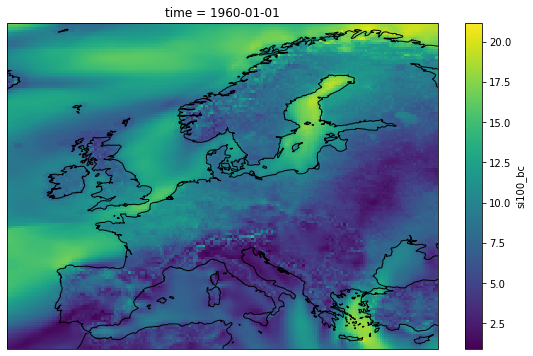

In [11]:
# Assuming obs_test is your xarray Dataset or DataArray
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
# include coastlines
ax.coastlines()
obs_test_subset["si100_bc"].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree())
plt.show()



In [13]:
obs_test_subset

<xarray.Dataset>
Dimensions:    (time: 731, longitude: 178, latitude: 135)
Coordinates:
  * time       (time) datetime64[ns] 1960-01-01 1960-01-02 ... 1961-12-31
  * longitude  (longitude) float32 -14.91 -14.62 -14.34 ... 34.31 34.59 34.88
  * latitude   (latitude) float32 71.8 71.52 71.24 70.96 ... 34.71 34.43 34.15
Data variables:
    si100_bc   (time, latitude, longitude) float64 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Aug 01 15:49:08 2024: cdo selyear,1960/1961 ERA5_si100_...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [6]:
# # load in the old_bc and new_bc
# old_bc = np.load(old_bc)
# new_bc = np.load(new_bc)

In [7]:
# # prtint the shape
# print(old_bc.shape)
# print(new_bc.shape)

In [8]:
# old_bc

In [9]:
# # remove the old bias correction by subtracting the old_bc from the obs
# si100_bc_values = obs_test["si100_bc"].values

# print(np.shape(si100_bc_values))

In [10]:
# si100_bc_values

In [11]:
# si100_values = si100_bc_values - old_bc

In [12]:
# si100_values

In [13]:
# # print the mean of the si100_bc_values
# print(np.mean(si100_bc_values))
# print(np.mean(si100_values))

In [14]:
# # assign the si100_values to obs_test
# # as a new variable "si100"
# obs_test["si100"] = (("time", "latitude", "longitude"), si100_values)

In [15]:
# obs_test

In [16]:
# # set up the save directory
# save_dir = "/gws/nopw/j04/canari/users/benhutch/ERA5/"
# save_fname = "ERA5_si100_si100_bc_daily_1960_2020.nc"

# # save the new obs_test
# obs_test.to_netcdf(save_dir + save_fname)

In [17]:
# Define the constants for testing Hannah's mask function
# Processing observations first
data_dir = "/gws/nopw/j04/canari/users/benhutch/ERA5/"
test_str = "ERA5_si100_bc_daily_1960_1961.nc"
cond = "si100_bc"
country = "United Kingdom"

# Tets the function
MASK_MATRIX_RESHAPE, LONS, LATS = hb_wind_func.country_mask(
    data_dir=data_dir, test_str=test_str, COND=cond, COUNTRY=country
)

(214, 304)
Found Country United Kingdom
making mask
(214, 304)


In [18]:
type(MASK_MATRIX_RESHAPE)

numpy.ndarray

In [19]:
# load the power curves
pc_ons_path = "/home/users/benhutch/Hannah_model/power_onshore.csv"
pc_ofs_path = "/home/users/benhutch/Hannah_model/power_offshore.csv"

# load the power curves
pc_winds, pc_power_ons, pc_power_ofs = hb_wind_func.load_power_curves(
    path_onshore_curve=pc_ons_path, path_offshore_curve=pc_ofs_path
)

In [20]:
# # Load in the wind farm locations
files_dir = "/home/users/benhutch/Hannah_model/installed_capacities/"
ons_wind_2021_fname = "United_Kingdomwindfarm_dist_ons_2021.nc"
ofs_wind_2021_fname = "United_Kingdomwindfarm_dist_ofs_2021.nc" 
hb_files_dir = "/home/users/benhutch/for_martin/for_martin/creating_wind_power_generation/"

# load in the wind farm locations with iris
ons_wind_2021_bh = iris.load_cube(os.path.join(files_dir, ons_wind_2021_fname))
ofs_wind_2021_bh = iris.load_cube(os.path.join(files_dir, ofs_wind_2021_fname))

# load in the wind farm locations with xarray
ons_wind_2021_hb = iris.load_cube(os.path.join(hb_files_dir, ons_wind_2021_fname))
ofs_wind_2021_hb = iris.load_cube(os.path.join(hb_files_dir, ofs_wind_2021_fname))

In [21]:
# extract the values
ons_wind_2021_bh_values = ons_wind_2021_bh.data
ofs_wind_2021_bh_values = ofs_wind_2021_bh.data

ons_wind_2021_hb_values = ons_wind_2021_hb.data
ofs_wind_2021_hb_values = ofs_wind_2021_hb.data

In [23]:
ons_wind_2021_bh_values

masked_array(
  data=[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [25]:
# print the mean of ons_wind_2021_bh_values
print(np.mean(ons_wind_2021_bh_values))
print(np.mean(ons_wind_2021_hb_values))

0.19336864
409.058953598023


In [26]:
print(np.mean(ofs_wind_2021_bh_values))
print(np.mean(ofs_wind_2021_hb_values))

0.15866025
335.6355477514389


In [24]:
# check whether bh and hb are the same
# different shapes?
np.allclose(ons_wind_2021_bh_values, ons_wind_2021_hb_values)

ValueError: operands could not be broadcast together with shapes (214,304) (153,201) 

In [21]:
# # add the cubes together
# wind_2021 = ons_wind_2021 + ofs_wind_2021

In [22]:
# # set up the fname for saving this file
# fname = "United_Kingdomwindfarm_dist_2021.nc"

# # save the file
# iris.save(wind_2021, os.path.join(files_dir, fname))

In [23]:
# # sum up the ons_wind_2021
# print("The total onshore wind capacity is: ", np.sum(ons_wind_2021.data))

# print("The total offshore wind capacity is: ", np.sum(ofs_wind_2021.data))

# print("The total wind capacity is: ", np.sum(wind_2021.data))

In [24]:
# Set up the path to the wind farm locations
wind_farm_path = "/home/users/benhutch/Hannah_model/installed_capacities/United_Kingdomwindfarm_dist_2021.nc"

# load as an irirs cube
wind_farm_cube = iris.load_cube(wind_farm_path)

regridded_windfarms_total_corrected = hb_wind_func.load_wind_farm_location(
    path_to_farm_locations=wind_farm_path,
    path_to_sample_datafile=obs_path_test,
    cube_cond=cond,
)

/home/users/benhutch/.local/lib/python3.10/site-packages/iris/analysis/cartography.py:413: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


In [25]:
regridded_windfarms_total_corrected.shape

(214, 304)

In [26]:
importlib.reload(hb_wind_func)

<module 'European_hourly_hub_height_winds_2023_model' from '/home/users/benhutch/unseen_functions/European_hourly_hub_height_winds_2023_model.py'>

In [27]:
data = iris.load(obs_path_old)

In [28]:
len(data)

1

In [29]:
# quantify the speed at hub height
wind_speed_path = obs_path_new # now with the full one
C1 = "100 metre U wind component"
C2 = "100 metre V wind component"
landmask = MASK_MATRIX_RESHAPE
hub_height = 100.0

corrected_speed_hubheight = hb_wind_func.load_wind_speed_and_take_to_hubheight(
    path_to_wind_speed=wind_speed_path,
    C1=C1,
    C2=C2,
    landmask=landmask,
    height_of_wind_speed=hub_height,
    corrected_var_name="si100_bc",
)

loading wind speed data
removing corrected wind speed data
calculating corrected wind speed data from U and V components


In [31]:
# set up the save directory
save_dir = "/gws/nopw/j04/canari/users/benhutch/ERA5/"

# set up the fname
save_fname = "ERA5_si100_bc_new_daily_1960_2020_hubheight.nc"

# save the corrected_speed_hubheight
# if the path does not already exist
if not os.path.exists(os.path.join(save_dir, save_fname)):
    iris.save(corrected_speed_hubheight, os.path.join(save_dir, save_fname))

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


In [17]:
importlib.reload(hb_wind_func)

<module 'European_hourly_hub_height_winds_2023_model' from '/home/users/benhutch/unseen_functions/European_hourly_hub_height_winds_2023_model.py'>

In [18]:
# set up the constants for conbverting to wind power
WP_data_combined, WP_data_ons, WP_data_ofs = hb_wind_func.convert_to_wind_power(
                pc_winds=pc_winds,
                pc_power_onshore=pc_power_ons,
                pc_power_offshore=pc_power_ofs,
                speed_hubheight=corrected_speed_hubheight,
                regridded_windfarms_total_corrected=regridded_windfarms_total_corrected,
                landmask=MASK_MATRIX_RESHAPE,
            )

/home/users/benhutch/.local/lib/python3.10/site-packages/iris/cube.py:3859: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'latitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'latitude'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'longitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'longitude'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))


In [19]:
weights_broadcast = iris.util.broadcast_to_shape(
    regridded_windfarms_total_corrected, np.shape(corrected_speed_hubheight), (1, 2)
)

speed_hubheight_timeseries = corrected_speed_hubheight.collapsed(
    ["latitude", "longitude"], iris.analysis.MEAN, weights=weights_broadcast
)

# convert to GW
WP_cf_timeseries_combined = (WP_data_combined / 1000.0) / (
    np.sum(regridded_windfarms_total_corrected) / 1000000
)

WP_cf_timeseries_ons = (WP_data_ons / 1000.0) / (
    np.sum(regridded_windfarms_total_corrected) / 1000000
)

WP_cf_timeseries_ofs = (WP_data_ofs / 1000.0) / (
    np.sum(regridded_windfarms_total_corrected) / 1000000
)

The mean is:  0.3877917649994739


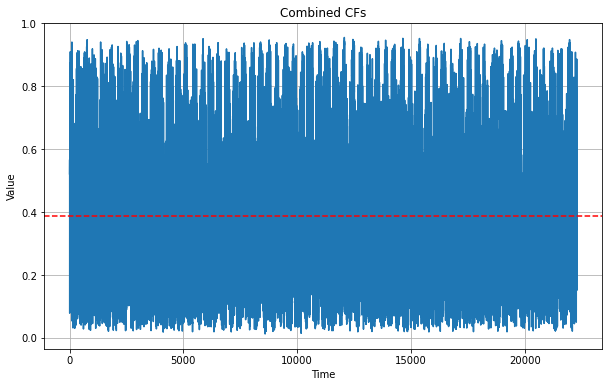

In [20]:
import matplotlib.pyplot as plt

# Assuming `WP_cf_timeseries` is your cube
cube_data = WP_cf_timeseries_combined.data
cube_time = WP_cf_timeseries_combined.coord('time').points

plt.figure(figsize=(10, 6))
plt.plot(cube_time, cube_data)

# plot the mean as a horizontal line
plt.axhline(y=np.mean(cube_data), color='r', linestyle='--')

# print the mean
print("The mean is: ", np.mean(cube_data))

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Combined CFs')
plt.grid(True)
plt.show()

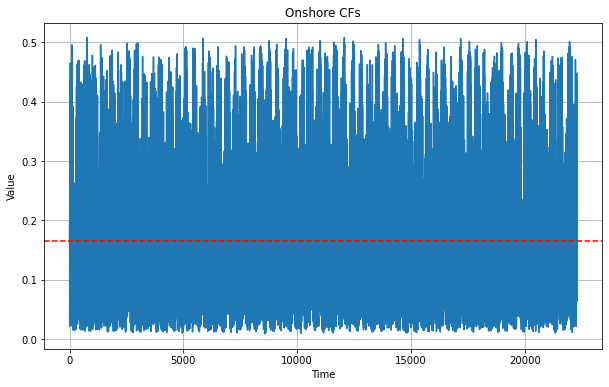

In [21]:
# Assuming `WP_cf_timeseries` is your cube
cube_data = WP_cf_timeseries_ons.data
cube_time = WP_cf_timeseries_ons.coord('time').points

plt.figure(figsize=(10, 6))
plt.plot(cube_time, cube_data)

# plot the mean as a horizontal line
plt.axhline(y=np.mean(cube_data), color='r', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Onshore CFs')
plt.grid(True)
plt.show()

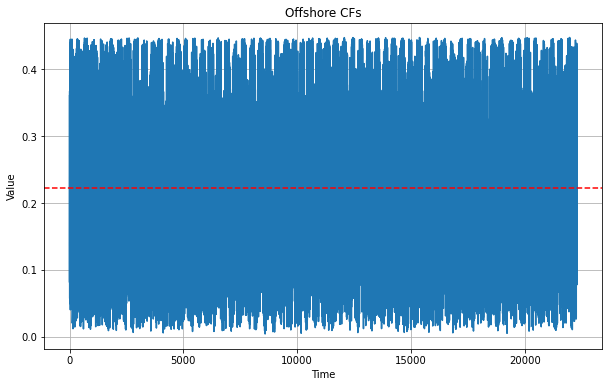

In [22]:
# Assuming `WP_cf_timeseries` is your cube
cube_data = WP_cf_timeseries_ofs.data
cube_time = WP_cf_timeseries_ofs.coord('time').points

plt.figure(figsize=(10, 6))
plt.plot(cube_time, cube_data)

# plot the mean as a horizontal line
plt.axhline(y=np.mean(cube_data), color='r', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Offshore CFs')
plt.grid(True)
plt.show()

In [24]:
# set up the save director
save_dir = "/home/users/benhutch/unseen_multi_year/saved_nc"

# set up the fnames
fname_combined = "United_Kingdom_wind_power_combined_1960_2020.nc"
fname_ons = "United_Kingdom_wind_power_ons_1960_2020.nc"
fname_ofs = "United_Kingdom_wind_power_ofs_1960_2020.nc"

# save the files
iris.save(WP_cf_timeseries_combined, os.path.join(save_dir, fname_combined))
iris.save(WP_cf_timeseries_ons, os.path.join(save_dir, fname_ons))
iris.save(WP_cf_timeseries_ofs, os.path.join(save_dir, fname_ofs))

### My own crappy code beneath ###

In [5]:
%%time
# Load the observations
test_model_ds = xr.open_dataset(test_file)

# Load and regrid the observations
obs_ds = bias_func.load_and_rg_obs(
    model_ds=test_model_ds,
    obs_variable=obs_variable,
    obs_path=obs_path_test,
    init_years=init_years,
    lead_time=lead_time,
    rg_algo="bilinear",
    grid_bounds=[-180.0, 180.0, -90.0, 90.0],
    periodic=True,
    parallel=False,
)

CPU times: user 5.09 s, sys: 267 ms, total: 5.36 s
Wall time: 6.08 s


In [6]:
%%time

# Select the gridbox
obs_ds = bias_func.select_gridbox(
    ds=obs_ds,
    grid=udicts.eu_grid_constrained,
    calc_mean=False,
)

CPU times: user 4.18 ms, sys: 64 µs, total: 4.24 ms
Wall time: 3.95 ms


In [7]:
# %%time

# Apply the country mask to the obs data
obs_ds = lw_func.apply_country_mask(
    ds=obs_ds,
    country=country,
    lon_name="lon",
    lat_name="lat",
)

Found the country!
Pre-country mask
<xarray.DataArray (y: 324, x: 432)>
dask.array<getitem, shape=(324, 432), dtype=float64, chunksize=(324, 432), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 1960-11-01
    lon      (x) float64 -179.6 -178.8 -177.9 -177.1 ... 177.1 177.9 178.7 179.6
    lat      (y) float64 -89.72 -89.17 -88.61 -88.06 ... 88.06 88.61 89.17 89.72
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear
[-179.58333336 -178.75000007 -177.91666678 -177.0833335  -176.25000021
 -175.41666693 -174.58333364 -173.75000035 -172.91666707 -172.08333378
 -171.2500005  -170.41666721 -169.58333392 -168.75000064 -167.91666735
 -167.08333406 -166.25000078 -165.41666749 -164.58333421 -163.75000092
 -162.91666763 -162.08333435 -161.25000106 -160.41666778 -159.58333449
 -158.7500012  -157.91666792 -157.08333463 -156.25000134 -155.41666806
 -154.58333477 -153.75000149 -152.9166682  -152.08333491 -151.25000163
 -150.41666834 -149.58333506 -148.75000

In [8]:
importlib.reload(lw_func)

<module 'load_wind_functions' from '/home/users/benhutch/unseen_functions/load_wind_functions.py'>

In [9]:
%%time

# Test the function for creating the wind power data
cfs, winds = lw_func.create_wind_power_data(
    ds=obs_ds,
    country=country_name,
    ons_ofs="ofs", # test offshore for now
    onshore_curve_file="/home/users/benhutch/Hannah_model/power_onshore.csv",
    offshore_curve_file="/home/users/benhutch/Hannah_model/power_offshore.csv",
    installed_capacities_dir="/home/users/benhutch/Hannah_model/installed_capacities/",
    lat_name="lat",
    lon_name="lon",
    obs_flag=True,
)

Loading in the installed capacities for offshore wind farms.
loading installed capacities from: /home/users/benhutch/Hannah_model/installed_capacities/United_Kingdomwindfarm_dist_ofs_2021.nc
Installed capacity: 10.3218 for United_Kingdom
Lats and lons are not the same.
Interpolating installed capacities to the same grid as the wind speed data.


ic_cube: totals / (unknown)                  (latitude: 214; longitude: 304)
    Dimension coordinates:
        latitude                             x               -
        longitude                            -               x
bc_si100_cube: unknown / (unknown)                 (time: 1887; latitude: 324; longitude: 432)
    Dimension coordinates:
        time                             x               -               -
        latitude                         -               x               -
        longitude                        -               -               x
    Attributes:
        regrid_method               'bilinear'
Installed capacity: 1.4514608 for United_Kingdom
Total MW pre shape: (214, 304)
Total MW regrid shape: (324, 432)
Processing the observations into wind power data.
bc_si100_vals shape: (1887, 214, 304)
Processing the offshore wind power data.
Loading in the offshore power curve.
wp_dist_masked_data shape: (1887, 214, 304)
totals_MW shape: (214, 304)
bc_si100

/home/users/benhutch/unseen_functions/load_wind_functions.py:910: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  power_curve = pd.read_csv(offshore_curve_file, header=None, sep="  ")


Power curve:              0         1
0     0.000000  0.000000
1     0.867818  0.000207
2     1.197841  0.001802
3     1.491166  0.001792
4     1.784469  0.003802
..         ...       ...
117  28.863661 -0.000861
118  29.383644 -0.000879
119  29.583638 -0.000886
120  29.970293 -0.000899
121  30.000000  0.000000

[122 rows x 2 columns]
Power curve shape: (122, 2)
Power curve:      Wind speed (m/s)  Capacity factors
0            0.000000          0.000000
1            0.867818          0.000207
2            1.197841          0.001802
3            1.491166          0.001792
4            1.784469          0.003802
..                ...               ...
117         28.863661         -0.000861
118         29.383644         -0.000879
119         29.583638         -0.000886
120         29.970293         -0.000899
121         30.000000          0.000000

[122 rows x 2 columns]
pc_winds: [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   

In [10]:
# loop over the time axis
for t in range(0, len(cfs)):
    # print the nanmean cfs
    print(f"Mean CF for time {t} is {np.nanmean(cfs[t])}")

Mean CF for time 0 is 0.0
Mean CF for time 1 is 0.0
Mean CF for time 2 is 0.0
Mean CF for time 3 is 0.0
Mean CF for time 4 is 0.0
Mean CF for time 5 is 0.0
Mean CF for time 6 is 0.0
Mean CF for time 7 is 0.0
Mean CF for time 8 is 0.0
Mean CF for time 9 is 0.0
Mean CF for time 10 is 0.0
Mean CF for time 11 is 0.0
Mean CF for time 12 is 0.0
Mean CF for time 13 is 0.0
Mean CF for time 14 is 0.0
Mean CF for time 15 is 0.0
Mean CF for time 16 is 0.0
Mean CF for time 17 is 0.0
Mean CF for time 18 is 0.0
Mean CF for time 19 is 0.0
Mean CF for time 20 is 0.0
Mean CF for time 21 is 0.0
Mean CF for time 22 is 0.0
Mean CF for time 23 is 0.0
Mean CF for time 24 is 0.0
Mean CF for time 25 is 0.0
Mean CF for time 26 is 0.0
Mean CF for time 27 is 0.0
Mean CF for time 28 is 0.0
Mean CF for time 29 is 0.0
Mean CF for time 30 is 0.0
Mean CF for time 31 is 0.0
Mean CF for time 32 is 0.0
Mean CF for time 33 is 0.0
Mean CF for time 34 is 0.0
Mean CF for time 35 is 0.0
Mean CF for time 36 is 0.0
Mean CF for

In [11]:
# plot the cfs
cfs.shape

(1887, 214, 304)

In [12]:
cfs_mean = np.nanmean(cfs, axis=(1, 2))

0.0

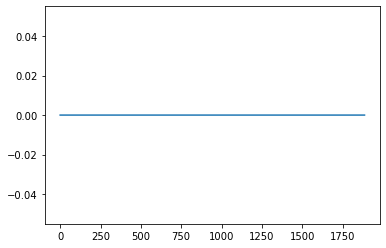

In [13]:
# plot the mean cfs
plt.plot(cfs_mean)

# calculate the mean
np.nanmean(cfs_mean)

In [11]:
for t in range(0, len(winds)):
    # print the nanmean winds
    print(f"Mean wind speed for time {t} is {np.nanmean(winds[t])}")

Mean wind speed for time 0 is 9.367329192054209
Mean wind speed for time 1 is 10.450712128101786
Mean wind speed for time 2 is 8.750189672585707
Mean wind speed for time 3 is 8.526153500990098
Mean wind speed for time 4 is 8.612112453469212
Mean wind speed for time 5 is 7.112970607127863
Mean wind speed for time 6 is 6.270275016321516
Mean wind speed for time 7 is 6.4765295788979325
Mean wind speed for time 8 is 6.808313166611069
Mean wind speed for time 9 is 9.576116305280529
Mean wind speed for time 10 is 9.065106904157876
Mean wind speed for time 11 is 8.59964729754357
Mean wind speed for time 12 is 8.349465538991518
Mean wind speed for time 13 is 8.243297376400482
Mean wind speed for time 14 is 7.834635295812557
Mean wind speed for time 15 is 7.481491235123399
Mean wind speed for time 16 is 7.763041236763631
Mean wind speed for time 17 is 6.859014988352663
Mean wind speed for time 18 is 6.676807386434244
Mean wind speed for time 19 is 7.115060778928508
Mean wind speed for time 20 i

In [12]:
# calculate the nanmean wind speed over the period
mean_wind = np.nanmean(winds)

print(f"Mean wind speed over the period is {mean_wind}")

Mean wind speed over the period is 7.364714520209988


In [15]:
type(totals_MW_pre)

numpy.ndarray

In [13]:
bc_si100_cube_regrid

<iris 'Cube' of unknown / (unknown) (time: 21548; latitude: 214; longitude: 304)>

In [10]:
# # create a dataframe of the wind speeds
# obs_ws_cfs_ofs_df = pd.DataFrame({
#     "time": obs_ds["time"].values,
#     "wind_speed": wind_speed_pre,
#     "cfs": cfs,
# })

In [11]:
# # replace the name of wind speed with obs_wind_speed_100m_bc
# obs_ws_cfs_ofs_df.rename(columns={"wind_speed": "obs_wind_speed_100m_bc"}, inplace=True)

# # replace the name of cfs with obs_cfs_ons
# obs_ws_cfs_ofs_df.rename(columns={"cfs": "obs_cfs_ofs"}, inplace=True)

In [12]:
# # set up the save dir
# save_dir = "/gws/nopw/j04/canari/users/benhutch/met_to_energy_dfs/"

# # set up the fname
# fname = f"{country_name}_obs_wind_speed_cfs_ofs.csv"

# # set up the save path
# save_path = os.path.join(save_dir, fname)

# # save the dataframe
# obs_ws_cfs_ofs_df.to_csv(save_path, index=False)

In [13]:
# wind_speed_post_obs = wind_speed_post

In [14]:
# import pandas as pd

# # Convert numpy array to pandas Series
# obs_ds_series = pd.Series(cfs)

# # # Apply a rolling mean (smooth) with a window size of 30
# smoothed_obs_ds = obs_ds_series.rolling(window=360).mean()

# # plot this with a smoothing of 30
# fig, ax = plt.subplots()
# plt.plot(smoothed_obs_ds)

In [15]:
# # %%time

# # # Form the wind power dataframe
# wind_power_df = lw_func.form_wind_power_dataframe(
#     cfs=cfs,
#     ds=obs_ds,
#     country_name=country_name,
# )

In [16]:
# # plot the wind power data with a smoothing of 30
# smooth30 = wind_power_df["United_Kingdom_wind_power"].rolling(window=30).mean()

# # plot this with a smoothing of 30
# fig, ax = plt.subplots()

# plt.plot(smooth30)

### Loading model data ###

Now that we have loaded the obs data, we now want to load the model data and process this into 100m wind speeds before converting to wind power.

In [17]:
importlib.reload(lw_func)

<module 'load_wind_functions' from '/home/users/benhutch/unseen_functions/load_wind_functions.py'>

In [18]:
%%time

# Set up the months of data to load
months = [11] # N test

# set up the base_dir
base_dir = "/work/scratch-nopw2/benhutch/test_nc/"

variable_saved = "__xarray_dataarray_variable__"

# Set up an empty dataframe
combined_df = pd.DataFrame()

# initialize an empty list for the cfs
cfs_list = []

# Loop over the months
for month_idx in tqdm(months):

    # Set up the fname
    fname_month = f"{variable}_bias_correction_HadGEM3-GC31-MM_lead{lead_time}_month{month_idx}_init{first_year}-{last_year}.nc"

    # set up the path
    path = os.path.join(base_dir, fname_month)

    # assert that the path exists
    assert os.path.exists(path), f"Path does not exist: {path}"

    # Select the european domain
    ds = bias_func.select_gridbox(
        ds=xr.open_dataset(path),
        grid=udicts.eu_grid_constrained,
        calc_mean=False,
    )

    # # Apply the country mask
    # ds = lw_func.apply_country_mask(
    #     ds=ds,
    #     country=country,
    #     lon_name="lon",
    #     lat_name="lat",
    # )

    # # print ds
    # print("ds type: ", type(ds))

    # # print ds type
    # print("type of ds[variable_saved]: ", type(ds[variable_saved]))

    # create wind power data
    totals_mw_pre, totals_mw_rg, wind_regrid, wind_normal = lw_func.create_wind_power_data(
        ds=ds,
        country=country_name,
        ons_ofs="ofs", # test onshore for now
        var_name=variable_saved,
        onshore_curve_file="/home/users/benhutch/Hannah_model/power_onshore.csv",
        offshore_curve_file="/home/users/benhutch/Hannah_model/power_offshore.csv",
        installed_capacities_dir="/home/users/benhutch/Hannah_model/installed_capacities/",
        lat_name="lat",
        lon_name="lon",
        corr_var_name="sfcWind",
        obs_flag=False,
    )

    # # print the shape of CFs    
    # print("cfs shape: ", cfs.shape)

    # # append the cfs to the list
    # cfs_list.append(cfs)

  0%|          | 0/1 [00:00<?, ?it/s]

Loading in the installed capacities for offshore wind farms.
loading installed capacities from: /home/users/benhutch/Hannah_model/installed_capacities/United_Kingdomwindfarm_dist_ofs_2021.nc
Installed capacity: 10.3218 for United_Kingdom
ds_test: <xarray.DataArray '__xarray_dataarray_variable__' (lat: 324, lon: 432)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    lead     int64 1
    init     int64 1960
    member   <U9 'r10i1p1f2'
  * lat      (lat) float64 -89.72 -89.17 -88.61 -88.06 ... 88.61 89.17 89.72
  * lon      (lon) float64 -179.6 -178.8 -177.9 -177.1 ... 177.9 178.7 179.6
Lats and lons are not the same.
Interpolating installed capacities to the same grid as the wind speed data.


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

ic_cube: totals / (unknown)                  (latitude: 214; longitude: 304)
    Dimension coordinates:
        latitude                             x               -
        longitude                            -               x
bc_si100_cube: sfcWind / (unknown)                 (latitude: 324; longitude: 432)
    Dimension coordinates:
        latitude                             x               -
        longitude                            -               x
    Scalar coordinates:
        init                        1960
        lead                        1
        member                      r10i1p1f2
Installed capacity: 1.4514608 for United_Kingdom
Total MW pre shape: (214, 304)
Total MW regrid shape: (324, 432)
CPU times: user 256 ms, sys: 464 ms, total: 719 ms
Wall time: 1.14 s


In [19]:
wind_regrid

<iris 'Cube' of sfcWind / (unknown) (latitude: 214; longitude: 304)>

In [20]:
wind_normal

<iris 'Cube' of sfcWind / (unknown) (latitude: 324; longitude: 432)>

In [20]:
totals_mw_pre.max()

0.7224

In [22]:
totals_mw_rg.max()

0.42386845

In [27]:
ic_cube.data.max()

722.4

In [30]:
bc_si100_cube.data.mean()

7.824508751139922

In [21]:
wind_regrid.data.mean()

7.316323010970194

In [22]:
totals_mw.max()

0.7224

In [19]:
print("cfs_list: ", cfs_list)

cfs_list:  [array([[[0.80050884, 0.60930189, 0.61848085, ..., 0.52339014,
         0.37104643, 0.06042947],
        [0.80096073, 0.63605825, 0.62571449, ..., 0.30063697,
         0.26908746, 0.31468432],
        [0.8009047 , 0.64526168, 0.6285922 , ..., 0.18925493,
         0.12954402, 0.08741891],
        ...,
        [0.79666487, 0.65125206, 0.62782693, ..., 0.24594576,
         0.16436792, 0.2365147 ],
        [0.80038536, 0.62852051, 0.62984055, ..., 0.57703675,
         0.83509026, 0.89059864],
        [0.79892864, 0.61640873, 0.62384228, ..., 0.16813298,
         0.50381877, 0.28878024]],

       [[0.59340621, 0.54114222, 0.23368536, ..., 0.31150757,
         0.28026928, 0.48921309],
        [0.60025196, 0.55724975, 0.23055481, ..., 0.60536837,
         0.60401428, 0.76141181],
        [0.59937128, 0.56031219, 0.22675237, ..., 0.24929014,
         0.14227111, 0.04812343],
        ...,
        [0.5968972 , 0.55137135, 0.22602271, ..., 0.25685807,
         0.30798354, 0.43813104],


In [20]:
np.shape(cfs_list)

(5, 59, 10, 30)

In [21]:
# create an array of values for the lead time
lead_time_array_1 = np.arange(1, 30 + 1, 1)
lead_time_array_2 = np.arange(31, 60 + 1, 1)
lead_time_array_3 = np.arange(61, 90 + 1, 1)
lead_time_array_4 = np.arange(91, 120 + 1, 1)
lead_time_array_5 = np.arange(121, 150 + 1, 1)


# combine the arrays with a list
lead_time_list = [
    lead_time_array_1,
    lead_time_array_2,
    lead_time_array_3,
    lead_time_array_4,
    lead_time_array_5,
]

In [22]:
lead_time_list

[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 array([31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
        48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]),
 array([61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
        78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]),
 array([ 91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120]),
 array([121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
        134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
        147, 148, 149, 150])]

In [23]:
np.shape(cfs_list)

(5, 59, 10, 30)

In [24]:
importlib.reload(lw_func)

<module 'load_wind_functions' from '/home/users/benhutch/unseen_functions/load_wind_functions.py'>

In [25]:
combined_df_test = pd.DataFrame()

In [26]:
for cfs, lead_time_array in zip(cfs_list, lead_time_list):
    print("cfs shape: ", cfs.shape)

    # Form the wind power dataframe
    wp_df = lw_func.form_wind_power_dataframe(
        cfs=cfs,
        ds=ds,
        country_name=country_name,
        obs_flag=False,
        model_fpath=test_file,
        init_years=[1960, 2018],
        leads=lead_time_array,
        ons_ofs="ofs",
    )

    # Append to the combined dataframe
    combined_df_test = pd.concat([combined_df_test, wp_df], ignore_index=True)

cfs shape:  (59, 10, 30)


Looping over init years: 0it [00:00, ?it/s]

Looping over init years: 59it [00:06,  9.46it/s]


cfs shape:  (59, 10, 30)


Looping over init years: 59it [00:06,  9.30it/s]


cfs shape:  (59, 10, 30)


Looping over init years: 59it [00:06,  9.25it/s]


cfs shape:  (59, 10, 30)


Looping over init years: 59it [00:06,  9.31it/s]


cfs shape:  (59, 10, 30)


Looping over init years: 59it [00:06,  9.34it/s]


In [27]:
combined_df_test.lead.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150])

In [28]:
combined_df_test.head()

,init,lead,member,United_Kingdom_wind_power_cfs_ofs
0,1960,1,1,0.800509
1,1960,1,2,0.800961
2,1960,1,3,0.800905
3,1960,1,4,0.803976
4,1960,1,5,0.802065


In [29]:
# set up the save dir
save_dir = "/gws/nopw/j04/canari/users/benhutch/met_to_energy_dfs/"

# assert that the save_dir exists
assert os.path.exists(save_dir), f"Path does not exist: {save_dir}"

# set up the fname
fname = f"{country_name}_wind_power_df_test_ofs_1960_2018_NDJFM.csv"

# set up the save path
save_path = os.path.join(save_dir, fname)

# if the file does not exist, save it
if not os.path.exists(save_path):
    combined_df_test.to_csv(save_path, index=False)

In [34]:
combined_df_test.head()

,init,lead,member,United_Kingdom_wind_power_cfs_ons
0,1960,1,1,0.682444
1,1960,1,2,0.681283
2,1960,1,3,0.684550
3,1960,1,4,0.687110
4,1960,1,5,0.685891


In [ ]:
# # add a lead column to combined_df
# # one for each unique date
# combined_df["lead"] = np.tile(np.arange(1, 31), len(combined_df) // 30)

In [ ]:
combined_df.head()

In [ ]:
# add lead column to wind_power_df
wind_power_df["lead"] = np.arange(1, len(wind_power_df) + 1)

In [ ]:
# # loop over the different members and plot the wind power data
# fig, ax = plt.subplots()

# for member in combined_df["member"].unique():
#     member_df = combined_df[combined_df["member"] == member]

#     # smooth the member by 10 days centred
#     member_df_smooth = member_df["cfs"].rolling(window=10).mean()

#     plt.plot(member_df["lead"], member_df_smooth, label=member)

# # # quantify a 5%-95% range
# # quantile_5 = member_df_smooth.groupby("lead")["cfs"].quantile(0.05)
# # quantile_95 = member_df_smooth.groupby("lead")["cfs"].quantile(0.95)

# # plt.fill_between(
# #     combined_df["lead"].unique(),
# #     quantile_5,
# #     quantile_95,
# #     alpha=0.2,
# #     color="black",
# #     label="5-95% range",
# # )

# # limit wind power data to 30 days
# wind_power_df_subset = wind_power_df.iloc[:30]

# # # plot the observed wind power data
# obs_smooth = wind_power_df_subset["United_Kingdom_wind_power"].rolling(window=10).mean()

# plt.plot(wind_power_df_subset["lead"], obs_smooth, label="observed", color="black")

# # plot the legend off to the side
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
wind_speed_post_obs.shape

In [ ]:
wind_speed_post.shape

In [ ]:
# get these into a dataframe
wind_speed_post_obs_df = pd.DataFrame(wind_speed_post_obs)

In [ ]:
# set up a lead column
wind_speed_post_obs_df["lead"] = np.arange(1, len(wind_speed_post_obs_df) + 1)

In [ ]:
# set up column names
wind_speed_post_obs_df.columns = ["obs_100m_wind_speed_bc", "lead"]

In [ ]:
wind_speed_post_obs_df

In [ ]:
wind_speed_dfs = []

# loop over shape of 1th dimension
for i in range(1, wind_speed_pre.shape[1] + 1):

    # get the wind speed
    wind_speed = wind_speed_pre[:, i - 1]

    # print the wind speed shape
    print("wind_speed shape: ", wind_speed.shape)

    # get these into a dataframe
    wind_speed_df = pd.DataFrame(
        {
            "wind_speed": wind_speed,
            "lead": [i] * len(wind_speed),
            "member": np.arange(1, wind_speed.shape[0] + 1),
        }
    )

    # append to the list
    wind_speed_dfs.append(wind_speed_df)

# concatenate the dataframes
wind_speed_df = pd.concat(wind_speed_dfs, ignore_index=True)

In [ ]:
wind_speed_df

In [ ]:
# set up a figure
fig, ax = plt.subplots()

# # subset df to 30 days
# wind_speed_pre_obs_df_subset = wind_speed_pre_obs_df.iloc[:30]

# take a rolling mean
obs_smooth = (
    wind_speed_pre_obs_df_subset["obs_10m_wind_speed"].rolling(window=10).mean()
)

# plot the observed wind speed
plt.plot(
    wind_speed_pre_obs_df_subset["lead"], obs_smooth, label="observed", color="black"
)

# loop over the different members and plot the wind power data
for member in wind_speed_df["member"].unique():
    member_df = wind_speed_df[wind_speed_df["member"] == member]

    # smooth the member by 10 days centred
    member_df_smooth = member_df["wind_speed"].rolling(window=10).mean()

    plt.plot(member_df["lead"], member_df_smooth, label=member)

# plot the legend off to the side
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# add a ylabel
plt.ylabel("10m wind speed (m/s)")